In [1]:
from automorphisms import *
from ZX_dualities import *
from utils.qec import *
from utils.qiskit import *
from utils.magma import *
import pickle

## [[108,8,10]] 

#### Define code

In [2]:
n = 108
k = 8
d = 10

H_X = np.load(f'../code_data/HX_n{n}k{k}d{d}.npy')
H_Z = np.load(f'../code_data/HZ_n{n}k{k}d{d}.npy')

zeros = np.zeros_like(H_X)
H_symp = np.array(np.vstack((np.hstack((H_X,zeros)),np.hstack((zeros,H_Z)))),dtype=int)

In [3]:
H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
assert H_symp_rref_og_basis.shape[0] == n-k
assert H_symp_rref_og_basis.shape[1] == 2*n

#### Standard form of code

In [4]:
G, LX, LZ, D = compute_standard_form(H_symp_rref_og_basis)

#### Logical basis in IBM paper

In [5]:
# unprimed block
X_unprimed = np.load(f'../code_data/n{n}k{k}d{d}_X_unprimed_mat.npy')
X_unprimed = np.array(np.hstack((X_unprimed, np.zeros_like(X_unprimed))),dtype=int)
Z_unprimed = np.load(f'../code_data/n{n}k{k}d{d}_Z_unprimed_mat.npy')
Z_unprimed = np.array(np.hstack((np.zeros_like(Z_unprimed),Z_unprimed)),dtype=int)

# primed block
X_primed = np.load(f'../code_data/n{n}k{k}d{d}_X_primed_mat.npy')
X_primed = np.array(np.hstack((X_primed, np.zeros_like(X_primed))),dtype=int)
Z_primed = np.load(f'../code_data/n{n}k{k}d{d}_Z_primed_mat.npy')
Z_primed = np.array(np.hstack((np.zeros_like(Z_primed),Z_primed)),dtype=int)

In [6]:
logicals_standard = np.vstack([LX,LZ])
logicals_ibm = np.vstack([X_unprimed,X_primed,Z_unprimed,Z_primed])
logicals_ibm_anticomm = np.vstack([Z_unprimed,Z_primed,X_unprimed,X_primed])

U_ibm_to_standard = symp_prod(logicals_standard,logicals_ibm_anticomm)

#### Automorphism group generators from MAGMA

In [7]:
#code_auts_dict = qec_code_ZX_dualities_from_magma_with_intersection(n,k,d,H_symp_rref_og_basis).run(fileroot='./')
filename = f'./ZX_dualities_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    code_auts_dict = pickle.load(f)
print('Aut Group Order: ', code_auts_dict['order'])
print('Time: ', code_auts_dict['time'])
print('No of aut gens: ', len(code_auts_dict['auts']))

Aut Group Order:  216
Time:  0.91
No of aut gens:  5


#### Circuits of automorphism group generators

In [8]:
auts = code_auts_dict['auts']
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    #print('Aut Gen',num)
    phys_act = circ_from_ZX_duality(H_symp_rref_og_basis,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp_rref_og_basis,phys_circ)
    symp_mat_standard = log_act.U_logical_act()
    symp_mat = inv_mod2(U_ibm_to_standard) @ symp_mat_standard @ U_ibm_to_standard %2
    circ = circ_from_symp_mat(symp_mat).run(), phys_circ
    circuits.append(circ)
    symp_mats.append(symp_mat)

In [9]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(symp_mats, f)

### Logical action 1

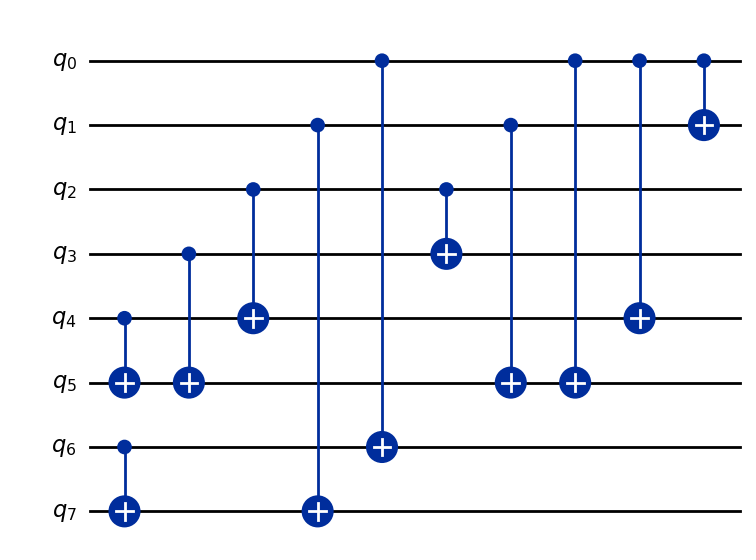

In [10]:
# logical circuit
log_act, phys_circ = circuits[0]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 2

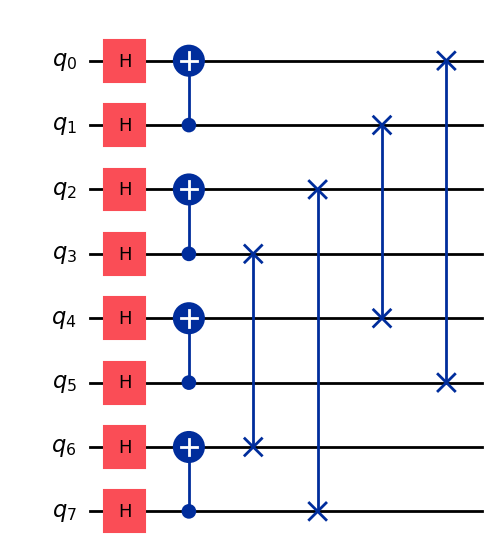

In [11]:
# logical circuit
log_act, phys_circ = circuits[1]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 3

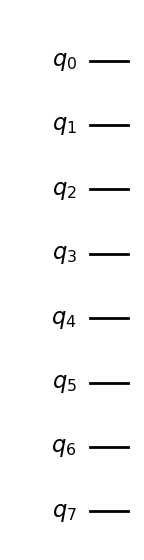

In [12]:
# logical circuit
log_act, phys_circ = circuits[2]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 4

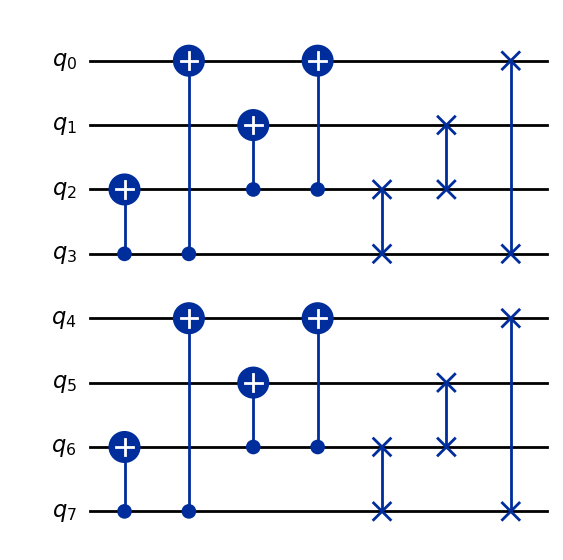

In [13]:
# logical circuit
log_act, phys_circ = circuits[3]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 5

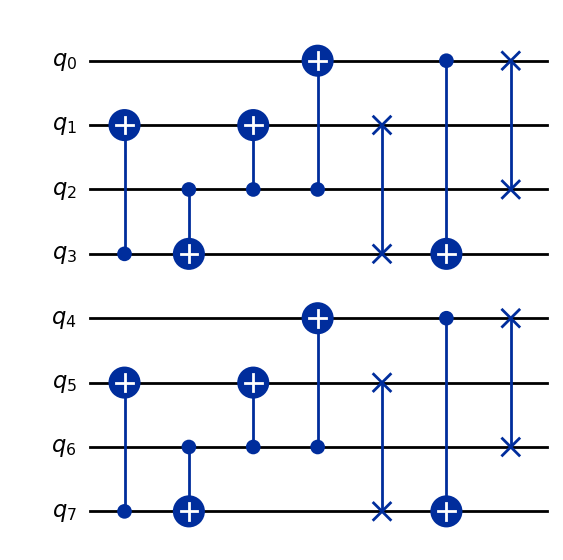

In [14]:
# logical circuit
log_act, phys_circ = circuits[4]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

## Logical gate group structure

In [15]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    symp_mats = pickle.load(f)

In [16]:
from logical_subgroups import *
gate_group = clifford_subgroups(k,symp_mats)
print(gate_group.return_order())
print(gate_group.return_structure())

36
S3^2


## Compare automorphisms with IBM paper

In [17]:
aut_x = np.load(f'../code_data/auts_from_paper/aut_x_n{n}k{k}d{d}.npy')
aut_y = np.load(f'../code_data/auts_from_paper/aut_y_n{n}k{k}d{d}.npy')

print(magma(MAGMA_define_SG(symp_mats,aut_x)))

Magma V2.28-8     Mon Sep 23 2024 10:23:52 on eduroam-int-dhcp-97-191-36 [Seed =
412044719]
Type ? for help.  Type <Ctrl>-D to quit.
Order: 36
Structure: S3^2
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
true

Total time: 0.070 seconds, Total memory usage: 184.72MB



In [18]:
print(magma(MAGMA_define_SG(symp_mats,aut_y)))

Magma V2.28-8     Mon Sep 23 2024 10:23:52 on eduroam-int-dhcp-97-191-36 [Seed =
310724517]
Type ? for help.  Type <Ctrl>-D to quit.
Order: 36
Structure: S3^2
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
true

Total time: 0.070 seconds, Total memory usage: 184.72MB

